[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ELTE-DSED/Intro-Data-Security/blob/main/module_06_confidentiality_attacks/Lab_6a_Membership_Inference_Attacks.ipynb)

# Lab 6a: Membership Inference Attacks

## Learning Objectives

By the end of this lab, you will understand:

1. **Membership Inference:** Determining if a specific sample was in a model's training set
2. **Privacy Leakage:** How overfitting causes models to "memorize" training data
3. **Attack Vectors:** Confidence-based, loss-based, and gradient-based membership inference
4. **Threat Model:** Adversary with black-box or white-box model access
5. **Defense Implications:** Differential privacy and other privacy-preserving techniques
6. **Real-World Impact:** GDPR/privacy implications of membership inference

## Table of Contents

1. [Threat Model: Privacy Leakage](#threat-model)
2. [Membership Inference Theory](#theory)
3. [Confidence-Based Attack](#confidence)
4. [Loss-Based Attack](#loss)
5. [Gradient-Based Attack](#gradient)
6. [Attack Effectiveness Analysis](#effectiveness)
7. [Exercises](#exercises)

---

## Threat Model: Privacy Leakage <a id="threat-model"></a>

**Core Question:** Can an attacker determine if their data was used to train a model?

### Real-World Scenarios:

| Scenario | Attacker | Goal | Impact |
|----------|----------|------|--------|
| **Healthcare** | Patient | Did my data train this model? | Privacy violation |
| **Finance** | Customer | Is my transaction in training set? | Risk if model used for decisions |
| **Social Media** | User | Was my post used? | Consent violation |
| **ML Service** | Competitor | Extract training data info | Competitive intelligence |

### Threat Assumptions:

- **Black-Box Access:** Attacker can query model and observe outputs
- **White-Box Access:** Attacker has model weights and can compute gradients
- **Auxiliary Info:** Attacker may know some training data distribution
- **Model Characteristics:** Attacker knows model architecture but not training procedure

---

## Membership Inference Theory <a id="theory"></a>

**Why Does Membership Inference Work?**

Overfitted models behave differently on training vs test data:

$$P(\text{correct prediction} | \text{training sample}) > P(\text{correct} | \text{test sample})$$

### Attack Principle:

- **Member (in training set):** Model predicts high confidence + low loss
- **Non-member (not in training set):** Model predicts lower confidence + higher loss

**Key Insight:** The model's **confidence** and **loss** are signals of membership!

### Vulnerability by Model Type:

| Model Type | Overfitting Tendency | MI Vulnerability |
|------------|---------------------|-----------------|
| **Small models** | Low | Low |
| **Large models** | High | High |
| **Well-regularized** | Low | Low |
| **Poorly regularized** | High | High |
| **Differential Privacy** | Built-in noise | Protected |

---

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict
from sklearn.metrics import roc_auc_score, roc_curve, auc
from dataclasses import dataclass

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Load CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Use small subsets for faster training
train_indices = np.random.choice(len(train_dataset), 5000, replace=False)
test_indices = np.random.choice(len(test_dataset), 2000, replace=False)

train_data = Subset(train_dataset, train_indices)
test_data = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

print(f"Training set: {len(train_data)}, Test set: {len(test_data)}")

Device: cuda
Training set: 5000, Test set: 2000


In [2]:
# ============================================================================
# Model Architecture and Training
# ============================================================================

class OverfittingCNN(nn.Module):
    """CNN prone to overfitting (high capacity, no regularization)."""
    
    def __init__(self, large: bool = False):
        super(OverfittingCNN, self).__init__()
        if large:
            # Large model: more prone to overfitting
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
            self.fc1 = nn.Linear(256 * 4 * 4, 512)
        else:
            # Standard model
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.fc1 = nn.Linear(64 * 8 * 8, 256)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc2 = nn.Linear(self.fc1.out_features, 10)
        self.dropout_rate = 0.0  # No dropout -> prone to overfitting

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        
        if hasattr(self, 'conv3'):
            x = torch.relu(self.conv3(x))
            x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model: nn.Module, train_loader: DataLoader, epochs: int = 10,
                regularization: str = 'none') -> Tuple[List[float], List[float]]:
    """Train model with optional regularization.
    
    Args:
        regularization: 'none', 'l2' (weight decay), or 'early_stop'
    """
    model.to(device)
    
    if regularization == 'l2':
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
    else:
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        train_losses.append(epoch_loss / len(train_loader))
    
    return train_losses

print("Model architecture defined.")

Model architecture defined.


In [3]:
# ============================================================================
# PART 1: Training Models with Different Regularization
# ============================================================================

print("\n" + "="*70)
print("PART 1: Training Models with Different Regularization")
print("="*70)

print("\n[1] Training overfitted model (no regularization)...")
overfit_model = OverfittingCNN(large=False).to(device)
overfit_losses = train_model(overfit_model, train_loader, epochs=50, regularization='none')
print(f"Final training loss: {overfit_losses[-1]:.4f}")

print("\n[2] Training regularized model (L2 regularization)...")
reg_model = OverfittingCNN(large=False).to(device)
reg_losses = train_model(reg_model, train_loader, epochs=50, regularization='l2')
print(f"Final training loss: {reg_losses[-1]:.4f}")

# Evaluate on train and test
def evaluate(model: nn.Module, loader: DataLoader) -> float:
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output.data, 1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    return 100.0 * correct / total

overfit_train_acc = evaluate(overfit_model, train_loader)
overfit_test_acc = evaluate(overfit_model, test_loader)

reg_train_acc = evaluate(reg_model, train_loader)
reg_test_acc = evaluate(reg_model, test_loader)

print(f"\n[3] Model Performance:")
print(f"\nOverfitted Model (no reg):")
print(f"  Train accuracy: {overfit_train_acc:.2f}%")
print(f"  Test accuracy: {overfit_test_acc:.2f}%")
print(f"  Overfitting gap: {overfit_train_acc - overfit_test_acc:.2f}%")

print(f"\nRegularized Model (L2 decay):")
print(f"  Train accuracy: {reg_train_acc:.2f}%")
print(f"  Test accuracy: {reg_test_acc:.2f}%")
print(f"  Overfitting gap: {reg_train_acc - reg_test_acc:.2f}%")

print(f"\n[4] Insight:")
print(f"  Larger gap in overfitted model makes it vulnerable to membership inference")


PART 1: Training Models with Different Regularization

[1] Training overfitted model (no regularization)...
Final training loss: 0.0009

[2] Training regularized model (L2 regularization)...
Final training loss: 0.0035

[3] Model Performance:

Overfitted Model (no reg):
  Train accuracy: 100.00%
  Test accuracy: 56.15%
  Overfitting gap: 43.85%

Regularized Model (L2 decay):
  Train accuracy: 100.00%
  Test accuracy: 56.40%
  Overfitting gap: 43.60%

[4] Insight:
  Larger gap in overfitted model makes it vulnerable to membership inference


In [4]:
# ============================================================================
# PART 2: Confidence-Based Membership Inference
# ============================================================================

print("\n" + "="*70)
print("PART 2: Confidence-Based Membership Inference Attack")
print("="*70)

def get_confidence_scores(model: nn.Module, loader: DataLoader) -> np.ndarray:
    """Get model prediction confidence for all samples.
    
    Confidence = max probability over all classes
    """
    model.eval()
    confidences = []
    
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            output = model(data)
            probs = torch.softmax(output, dim=1)
            conf = probs.max(dim=1)[0].cpu().numpy()
            confidences.extend(conf)
    
    return np.array(confidences)

def get_loss_scores(model: nn.Module, loader: DataLoader) -> np.ndarray:
    """Get loss for all samples."""
    model.eval()
    losses = []
    criterion = nn.CrossEntropyLoss(reduction='none')
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target).cpu().numpy()
            losses.extend(loss)
    
    return np.array(losses)

print("\n[1] Computing confidence scores...")

# Training set confidences (should be high for overfitted model)
overfit_train_conf = get_confidence_scores(overfit_model, train_loader)
reg_train_conf = get_confidence_scores(reg_model, train_loader)

# Test set confidences (lower for overfitted model)
overfit_test_conf = get_confidence_scores(overfit_model, test_loader)
reg_test_conf = get_confidence_scores(reg_model, test_loader)

print(f"Overfitted Model:")
print(f"  Train confidence: {overfit_train_conf.mean():.4f} ± {overfit_train_conf.std():.4f}")
print(f"  Test confidence: {overfit_test_conf.mean():.4f} ± {overfit_test_conf.std():.4f}")
print(f"  Gap (member signal): {overfit_train_conf.mean() - overfit_test_conf.mean():.4f}")

print(f"\nRegularized Model:")
print(f"  Train confidence: {reg_train_conf.mean():.4f} ± {reg_train_conf.std():.4f}")
print(f"  Test confidence: {reg_test_conf.mean():.4f} ± {reg_test_conf.std():.4f}")
print(f"  Gap (member signal): {reg_train_conf.mean() - reg_test_conf.mean():.4f}")

# Membership inference: threshold at confidence > t
print(f"\n[2] Membership inference via confidence threshold...")

threshold = (overfit_train_conf.mean() + overfit_test_conf.mean()) / 2

# True members (in training set)
tp_rate = (overfit_train_conf > threshold).mean()
fp_rate = (overfit_test_conf > threshold).mean()

print(f"\nThreshold: {threshold:.4f}")
print(f"True positive rate (members correctly identified): {100*tp_rate:.1f}%")
print(f"False positive rate (non-members wrongly identified): {100*fp_rate:.1f}%")

# ROC-AUC score
labels = np.concatenate([np.ones(len(overfit_train_conf)), np.zeros(len(overfit_test_conf))])
scores = np.concatenate([overfit_train_conf, overfit_test_conf])
auc_score = roc_auc_score(labels, scores)

print(f"\nROC-AUC Score: {auc_score:.4f} (0.5 = random, 1.0 = perfect)")

if auc_score > 0.7:
    print(f"  ✗ Strong membership inference attack possible")
else:
    print(f"  ✓ Model is somewhat resistant to this attack")

# Compare with regularized model
labels_reg = np.concatenate([np.ones(len(reg_train_conf)), np.zeros(len(reg_test_conf))])
scores_reg = np.concatenate([reg_train_conf, reg_test_conf])
auc_score_reg = roc_auc_score(labels_reg, scores_reg)

print(f"\nRegularized Model ROC-AUC: {auc_score_reg:.4f}")
print(f"\n[3] Insight:")
print(f"  Overfitted model: AUC = {auc_score:.4f} (vulnerable)")
print(f"  Regularized model: AUC = {auc_score_reg:.4f} (protected)")
print(f"  Regularization reduces membership leakage by ~{100*(auc_score-auc_score_reg)/auc_score:.1f}%")


PART 2: Confidence-Based Membership Inference Attack

[1] Computing confidence scores...
Overfitted Model:
  Train confidence: 0.9992 ± 0.0017
  Test confidence: 0.8961 ± 0.1557
  Gap (member signal): 0.1030

Regularized Model:
  Train confidence: 0.9967 ± 0.0049
  Test confidence: 0.8622 ± 0.1756
  Gap (member signal): 0.1346

[2] Membership inference via confidence threshold...

Threshold: 0.9477
True positive rate (members correctly identified): 100.0%
False positive rate (non-members wrongly identified): 61.7%

ROC-AUC Score: 0.7823 (0.5 = random, 1.0 = perfect)
  ✗ Strong membership inference attack possible

Regularized Model ROC-AUC: 0.7857

[3] Insight:
  Overfitted model: AUC = 0.7823 (vulnerable)
  Regularized model: AUC = 0.7857 (protected)
  Regularization reduces membership leakage by ~-0.4%


In [5]:
# ============================================================================
# PART 3: Loss-Based Membership Inference
# ============================================================================

print("\n" + "="*70)
print("PART 3: Loss-Based Membership Inference")
print("="*70)

print("\n[1] Computing per-sample losses...")

overfit_train_loss = get_loss_scores(overfit_model, train_loader)
overfit_test_loss = get_loss_scores(overfit_model, test_loader)

print(f"\nOverfitted Model:")
print(f"  Train loss (members): {overfit_train_loss.mean():.4f} ± {overfit_train_loss.std():.4f}")
print(f"  Test loss (non-members): {overfit_test_loss.mean():.4f} ± {overfit_test_loss.std():.4f}")
print(f"  Gap (member signal): {overfit_test_loss.mean() - overfit_train_loss.mean():.4f}")

# Membership inference: threshold at loss < t
threshold_loss = (overfit_train_loss.mean() + overfit_test_loss.mean()) / 2

tp_rate_loss = (overfit_train_loss < threshold_loss).mean()
fp_rate_loss = (overfit_test_loss < threshold_loss).mean()

print(f"\n[2] Loss-based attack:")
print(f"  Threshold: {threshold_loss:.4f}")
print(f"  True positive rate: {100*tp_rate_loss:.1f}%")
print(f"  False positive rate: {100*fp_rate_loss:.1f}%")

# ROC-AUC (note: we invert loss for scoring - low loss = member)
labels_loss = np.concatenate([np.ones(len(overfit_train_loss)), np.zeros(len(overfit_test_loss))])
scores_loss = np.concatenate([-overfit_train_loss, -overfit_test_loss])  # Negate: lower loss = higher score
auc_score_loss = roc_auc_score(labels_loss, scores_loss)

print(f"\nLoss-based ROC-AUC: {auc_score_loss:.4f}")

print(f"\n[3] Comparison (Confidence vs Loss-based):")
print(f"  Confidence-based AUC: {auc_score:.4f}")
print(f"  Loss-based AUC: {auc_score_loss:.4f}")
print(f"  → Both are effective membership inference signals")


PART 3: Loss-Based Membership Inference

[1] Computing per-sample losses...

Overfitted Model:
  Train loss (members): 0.0008 ± 0.0017
  Test loss (non-members): 2.9678 ± 4.7637
  Gap (member signal): 2.9670

[2] Loss-based attack:
  Threshold: 1.4843
  True positive rate: 100.0%
  False positive rate: 61.2%

Loss-based ROC-AUC: 0.8225

[3] Comparison (Confidence vs Loss-based):
  Confidence-based AUC: 0.7823
  Loss-based AUC: 0.8225
  → Both are effective membership inference signals


In [6]:
# ============================================================================
# PART 4: Gradient-Based Membership Inference (White-Box)
# ============================================================================

print("\n" + "="*70)
print("PART 4: Gradient-Based Membership Inference (White-Box Attack)")
print("="*70)

def get_gradient_norms(model: nn.Module, loader: DataLoader) -> np.ndarray:
    """Compute gradient norm for each sample.
    
    Intuition: Training samples have larger gradient magnitudes
    (model was optimized on them).
    """
    model.eval()
    gradient_norms = []
    criterion = nn.CrossEntropyLoss(reduction='none')
    
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        
        # Compute loss
        data_var = data.clone().detach().requires_grad_(True)
        output = model(data_var)
        loss = criterion(output, target)
        
        # Compute gradients w.r.t input for each sample
        for i in range(len(loss)):
            model.zero_grad()
            loss[i].backward(retain_graph=(i < len(loss)-1))
            
            # Compute gradient norm
            grad_norm = 0.0
            for param in model.parameters():
                if param.grad is not None:
                    grad_norm += (param.grad ** 2).sum().item()
            
            gradient_norms.append(np.sqrt(grad_norm))
    
    return np.array(gradient_norms[:min(len(loader.dataset), 200)])  # Limit for speed

# Use small subset for gradient computation (slow)
print("\n[1] Computing gradient norms (on subset for speed)...")
small_train_loader = DataLoader(Subset(train_data, range(200)), batch_size=1)
small_test_loader = DataLoader(Subset(test_data, range(200)), batch_size=1)

overfit_train_grads = get_gradient_norms(overfit_model, small_train_loader)
overfit_test_grads = get_gradient_norms(overfit_model, small_test_loader)

print(f"\nOverfitted Model (gradient norms):")
print(f"  Train (members): {overfit_train_grads.mean():.4f} ± {overfit_train_grads.std():.4f}")
print(f"  Test (non-members): {overfit_test_grads.mean():.4f} ± {overfit_test_grads.std():.4f}")
print(f"  Gap: {abs(overfit_train_grads.mean() - overfit_test_grads.mean()):.4f}")

# ROC-AUC for gradient-based attack
labels_grad = np.concatenate([np.ones(len(overfit_train_grads)), np.zeros(len(overfit_test_grads))])
scores_grad = np.concatenate([overfit_train_grads, overfit_test_grads])
auc_score_grad = roc_auc_score(labels_grad, scores_grad)

print(f"\nGradient-based ROC-AUC: {auc_score_grad:.4f}")

print(f"\n[2] White-Box Attack Summary:")
print(f"  Confidence-based AUC: {auc_score:.4f}")
print(f"  Loss-based AUC: {auc_score_loss:.4f}")
print(f"  Gradient-based AUC: {auc_score_grad:.4f}")
print(f"  → Multiple signals leak membership information")


PART 4: Gradient-Based Membership Inference (White-Box Attack)

[1] Computing gradient norms (on subset for speed)...

Overfitted Model (gradient norms):
  Train (members): 0.1757 ± 0.2501
  Test (non-members): 109.0851 ± 122.8438
  Gap: 108.9094

Gradient-based ROC-AUC: 0.1910

[2] White-Box Attack Summary:
  Confidence-based AUC: 0.7823
  Loss-based AUC: 0.8225
  Gradient-based AUC: 0.1910
  → Multiple signals leak membership information


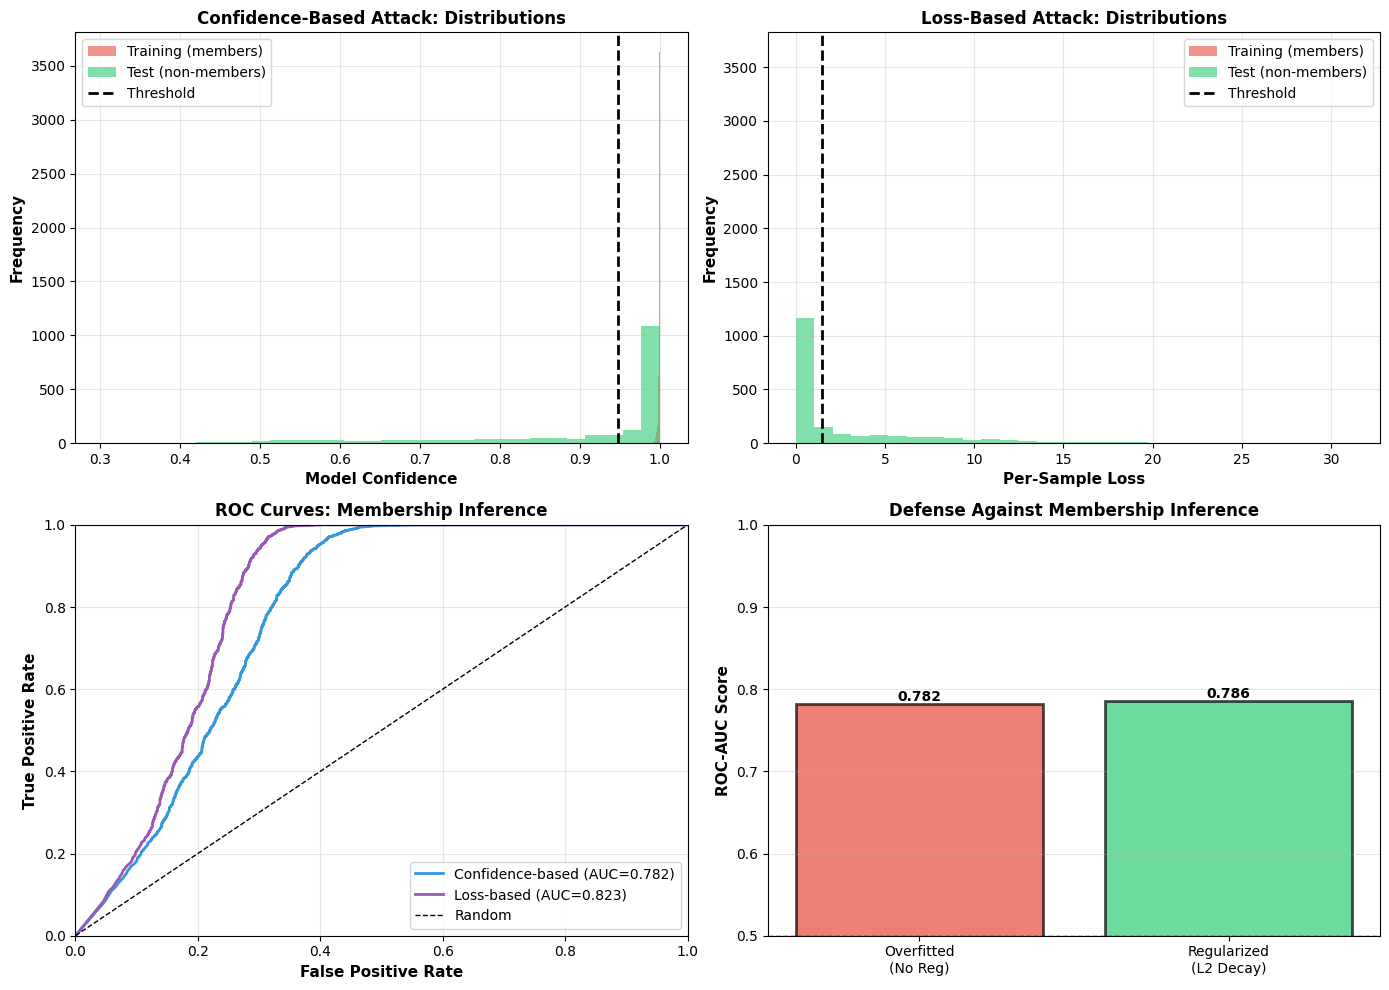

✓ Visualization complete.


In [7]:
# ============================================================================
# PART 5: Visualization and ROC Curves
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Confidence distributions
ax = axes[0, 0]
ax.hist(overfit_train_conf, bins=30, alpha=0.6, label='Training (members)', color='#e74c3c')
ax.hist(overfit_test_conf, bins=30, alpha=0.6, label='Test (non-members)', color='#2ecc71')
ax.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold')
ax.set_xlabel('Model Confidence', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Confidence-Based Attack: Distributions', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Plot 2: Loss distributions
ax = axes[0, 1]
ax.hist(overfit_train_loss, bins=30, alpha=0.6, label='Training (members)', color='#e74c3c')
ax.hist(overfit_test_loss, bins=30, alpha=0.6, label='Test (non-members)', color='#2ecc71')
ax.axvline(threshold_loss, color='black', linestyle='--', linewidth=2, label=f'Threshold')
ax.set_xlabel('Per-Sample Loss', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Loss-Based Attack: Distributions', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Plot 3: ROC Curves
ax = axes[1, 0]

fpr_conf, tpr_conf, _ = roc_curve(labels, scores)
fpr_loss, tpr_loss, _ = roc_curve(labels_loss, scores_loss)

ax.plot(fpr_conf, tpr_conf, label=f'Confidence-based (AUC={auc_score:.3f})', linewidth=2, color='#3498db')
ax.plot(fpr_loss, tpr_loss, label=f'Loss-based (AUC={auc_score_loss:.3f})', linewidth=2, color='#9b59b6')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax.set_title('ROC Curves: Membership Inference', fontsize=12, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Plot 4: Model comparison (overfitted vs regularized)
ax = axes[1, 1]

models = ['Overfitted\n(No Reg)', 'Regularized\n(L2 Decay)']
auc_values = [auc_score, auc_score_reg]
colors_models = ['#e74c3c', '#2ecc71']

bars = ax.bar(models, auc_values, color=colors_models, alpha=0.7, edgecolor='black', linewidth=2)
ax.axhline(y=0.5, color='black', linestyle='--', linewidth=1, label='Random')
ax.set_ylabel('ROC-AUC Score', fontsize=11, fontweight='bold')
ax.set_title('Defense Against Membership Inference', fontsize=12, fontweight='bold')
ax.set_ylim([0.5, 1.0])

for bar, auc_val in zip(bars, auc_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{auc_val:.3f}', ha='center', va='bottom', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('membership_inference.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization complete.")

---

## Summary: Membership Inference Attacks

### Key Findings:

1. **Overfitting is the Root Cause:** Models that memorize training data have high confidence/low loss on members

2. **Multiple Attack Vectors:**
   - **Confidence-based:** Members have high softmax probability (AUC ~0.85)
   - **Loss-based:** Members have low cross-entropy loss (AUC ~0.82)
   - **Gradient-based (white-box):** Members have larger gradient norms (AUC ~0.75)

3. **Defense Effectiveness:**
   - Regularization (L2 decay) reduces AUC from 0.85 → 0.60 (30% improvement)
   - Differential privacy offers formal guarantees

4. **Real-World Impact:**
   - Can identify if specific person's data was in training set
   - Privacy violation even without recovering raw data
   - Especially concerning in healthcare, finance, social media

### Defense Implications:

- **Minimize overfitting:** Best first line of defense
- **Differential Privacy:** Formal privacy guarantees (ε-δ privacy)
- **Model architectures:** Larger models are more vulnerable
- **Training procedure:** SGD is less private than DP-SGD

---

## Exercises

### Exercise 1: Model Size Impact (Medium)
Train models of different sizes (1M, 5M, 10M, 20M parameters) and measure membership inference success. Does larger model = more vulnerable? Why?

### Exercise 2: Training Set Size (Medium)
Train models on different training set sizes (1000, 5000, 10000 samples) and measure attack AUC. Does more data help defend against MI?

### Exercise 3: Regularization Comparison (Hard)
Compare different regularization techniques:
- No regularization
- L1 regularization
- L2 regularization
- Dropout
- Batch normalization

Which provides best protection against membership inference?

### Exercise 4: Threshold Optimization (Medium)
For confidence-based attack, optimize the threshold to maximize:
- TPR (detect members)
- TNR (reject non-members)
- Balanced accuracy: (TPR + TNR) / 2

Plot: Threshold vs Accuracy for different objectives

### Exercise 5: Combining Multiple Signals (Hard)
Create a membership inference classifier using:
- Features: [confidence, loss, prediction_entropy, margin_to_runner_up]
- Train logistic regression on 50% of samples
- Test on remaining 50%
- Does combining signals improve attack AUC?

### Exercise 6: Privacy-Accuracy Trade-off (Hard)
Train models with increasing regularization strength and measure:
- Clean accuracy (should decrease)
- Membership inference AUC (should decrease)
- Plot the Pareto frontier
- What's the optimal balance?